In [169]:
#!/usr/bin/env python
# coding: utf-8

In[35]:

*pip* install torch torchvision numpy matplotlib

In [170]:
import torch
import torchvision
from torch import nn
import torch.nn as nn;
import torch.nn.functional as func
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
#get_ipython().run_line_magic('matplotlib', 'inline')
import detectors
import timm
from torch.utils.data import ConcatDataset
import torch.nn.functional as F


In [171]:
model = timm.create_model("resnet18_cifar10", pretrained=True)

In[36]:

Train transformation

In [172]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation((-7,7)),  
    transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)), 
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
])
# Test transformation
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.491, 0.482, 0.446), (0.247, 0.243, 0.261))
])

Download training data from open datasets.

In [173]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=train_transform,
)

Files already downloaded and verified


Download test data from open datasets.

In [174]:
test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=test_transform,
)

Files already downloaded and verified


In[37]:

Training batch size

In [175]:
batch_size = 256

Create data loaders.

In [176]:
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [177]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(15,15))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In[38]:

Get cpu or gpu device for training.

In [178]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))
print(torch.__version__)


Using cuda device
2.1.1+cu121


Define model

In [179]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(3 * 32 * 32, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        logits = self.linear_relu_stack(x)
        return logits

In [180]:
model = NeuralNetwork().to(device)

In[39]:

Get cpu or gpu device for training.

In [181]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cuda device


Define model

In [182]:
class BasicBlock(nn.Module):
    expansion = 1
    

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()

        DROPOUT = 0.1

        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.dropout = nn.Dropout(DROPOUT)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes),
                nn.Dropout(DROPOUT)
            )

    def forward(self, x):
        out = F.relu(self.dropout(self.bn1(self.conv1(x))))
        out = self.dropout(self.bn2(self.conv2(out)))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return F.log_softmax(out, dim=-1)


def ResNet18():
    return ResNet(BasicBlock, [2, 2, 2, 2])

In [183]:
model = ResNet18().to(device)

In [184]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1,

In[40]:

Loss function

In [185]:
loss_fn = nn.CrossEntropyLoss()

SGD Optimizer

In [186]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In[41]:

Training function

In [187]:
def train(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.train()
    train_loss, correct = 0, 0
    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
        # record loss
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    train_loss /= len(dataloader)
    correct /= size

    print(f" Train accuracy: {(100*correct):>0.1f}%, Avg loss: {train_loss:>8f}")
    return train_loss, correct

In[42]:

Test function

In [188]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    # Turn on evalution mode
    model.eval()
    test_loss, correct = 0, 0

    # Turn off gradient descent
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            pred = model(X)

            # record loss
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size

    print(f" Test accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}")
    return correct

In[49]:

Total training epochs

In [189]:
epochs = 100
training_losses = []
training_accuracy = []
testing_accuracy = []






for t in range(epochs):
    print('\n', "=" * 15, "Epoch", t + 1, "=" * 15)
    loss, train_accuracy = train(train_dataloader, model, loss_fn)
    test_accuracy = test(test_dataloader, model, loss_fn)
    training_losses.append(loss)
    training_accuracy.append(train_accuracy)
    testing_accuracy.append(test_accuracy)

print(" Done!")


 =============== Epoch 1 ===============


  0%|          | 0/196 [00:00<?, ?it/s]

100%|██████████| 196/196 [01:16<00:00,  2.56it/s]


 Train accuracy: 40.1%, Avg loss: 1.622307


100%|██████████| 40/40 [00:04<00:00,  8.57it/s]


 Test accuracy: 53.4%, Avg loss: 1.316397

 =============== Epoch 2 ===============


100%|██████████| 196/196 [01:16<00:00,  2.57it/s]


 Train accuracy: 57.5%, Avg loss: 1.179837


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 64.6%, Avg loss: 0.998906

 =============== Epoch 3 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 64.7%, Avg loss: 0.989540


100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


 Test accuracy: 69.3%, Avg loss: 0.881732

 =============== Epoch 4 ===============


100%|██████████| 196/196 [01:16<00:00,  2.57it/s]


 Train accuracy: 70.1%, Avg loss: 0.846201


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 74.0%, Avg loss: 0.779895

 =============== Epoch 5 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 73.7%, Avg loss: 0.747745


100%|██████████| 40/40 [00:04<00:00,  8.57it/s]


 Test accuracy: 76.6%, Avg loss: 0.694078

 =============== Epoch 6 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 76.1%, Avg loss: 0.681332


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


 Test accuracy: 77.5%, Avg loss: 0.665033

 =============== Epoch 7 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 78.2%, Avg loss: 0.629006


100%|██████████| 40/40 [00:04<00:00,  8.54it/s]


 Test accuracy: 79.9%, Avg loss: 0.615208

 =============== Epoch 8 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 79.6%, Avg loss: 0.582103


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 81.2%, Avg loss: 0.557435

 =============== Epoch 9 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 80.7%, Avg loss: 0.550816


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


 Test accuracy: 82.4%, Avg loss: 0.533977

 =============== Epoch 10 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 81.9%, Avg loss: 0.514882


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 82.7%, Avg loss: 0.514620

 =============== Epoch 11 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 82.8%, Avg loss: 0.487201


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 83.0%, Avg loss: 0.508555

 =============== Epoch 12 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 83.4%, Avg loss: 0.467022


100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


 Test accuracy: 84.8%, Avg loss: 0.442906

 =============== Epoch 13 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 84.3%, Avg loss: 0.443600


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


 Test accuracy: 84.5%, Avg loss: 0.462303

 =============== Epoch 14 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 84.6%, Avg loss: 0.430880


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 85.6%, Avg loss: 0.425737

 =============== Epoch 15 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 85.6%, Avg loss: 0.408669


100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


 Test accuracy: 85.3%, Avg loss: 0.448091

 =============== Epoch 16 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 86.2%, Avg loss: 0.392408


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 86.6%, Avg loss: 0.404770

 =============== Epoch 17 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 86.7%, Avg loss: 0.374575


100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


 Test accuracy: 86.7%, Avg loss: 0.394432

 =============== Epoch 18 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 87.4%, Avg loss: 0.356655


100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


 Test accuracy: 86.0%, Avg loss: 0.424681

 =============== Epoch 19 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 87.4%, Avg loss: 0.351529


100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


 Test accuracy: 86.4%, Avg loss: 0.400153

 =============== Epoch 20 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 87.9%, Avg loss: 0.336518


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 87.6%, Avg loss: 0.376145

 =============== Epoch 21 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 88.8%, Avg loss: 0.319013


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


 Test accuracy: 87.1%, Avg loss: 0.386251

 =============== Epoch 22 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 89.1%, Avg loss: 0.310263


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


 Test accuracy: 87.4%, Avg loss: 0.387242

 =============== Epoch 23 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 89.3%, Avg loss: 0.303618


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 86.9%, Avg loss: 0.410099

 =============== Epoch 24 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 89.8%, Avg loss: 0.288604


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


 Test accuracy: 87.9%, Avg loss: 0.370838

 =============== Epoch 25 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 90.1%, Avg loss: 0.277809


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


 Test accuracy: 88.1%, Avg loss: 0.369823

 =============== Epoch 26 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 90.2%, Avg loss: 0.273595


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


 Test accuracy: 88.5%, Avg loss: 0.364050

 =============== Epoch 27 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 90.4%, Avg loss: 0.269129


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


 Test accuracy: 88.0%, Avg loss: 0.374563

 =============== Epoch 28 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 90.9%, Avg loss: 0.253931


100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


 Test accuracy: 88.4%, Avg loss: 0.379676

 =============== Epoch 29 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 91.0%, Avg loss: 0.253141


100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


 Test accuracy: 88.6%, Avg loss: 0.371793

 =============== Epoch 30 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 91.2%, Avg loss: 0.243071


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


 Test accuracy: 88.6%, Avg loss: 0.379539

 =============== Epoch 31 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 91.6%, Avg loss: 0.235475


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


 Test accuracy: 88.2%, Avg loss: 0.385819

 =============== Epoch 32 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 91.8%, Avg loss: 0.225866


100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


 Test accuracy: 88.6%, Avg loss: 0.361409

 =============== Epoch 33 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 91.9%, Avg loss: 0.226759


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 88.9%, Avg loss: 0.375374

 =============== Epoch 34 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 92.4%, Avg loss: 0.212900


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 88.2%, Avg loss: 0.395567

 =============== Epoch 35 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 92.5%, Avg loss: 0.205201


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


 Test accuracy: 88.7%, Avg loss: 0.384316

 =============== Epoch 36 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 92.7%, Avg loss: 0.202579


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 88.6%, Avg loss: 0.377108

 =============== Epoch 37 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 92.8%, Avg loss: 0.200135


100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


 Test accuracy: 88.1%, Avg loss: 0.415346

 =============== Epoch 38 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 93.3%, Avg loss: 0.190208


100%|██████████| 40/40 [00:04<00:00,  8.55it/s]


 Test accuracy: 89.5%, Avg loss: 0.364582

 =============== Epoch 39 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 93.1%, Avg loss: 0.189255


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 89.1%, Avg loss: 0.359592

 =============== Epoch 40 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 93.7%, Avg loss: 0.176347


100%|██████████| 40/40 [00:04<00:00,  8.50it/s]


 Test accuracy: 87.8%, Avg loss: 0.414881

 =============== Epoch 41 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 93.7%, Avg loss: 0.176058


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


 Test accuracy: 88.6%, Avg loss: 0.410903

 =============== Epoch 42 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 94.1%, Avg loss: 0.167081


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 88.6%, Avg loss: 0.404817

 =============== Epoch 43 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 93.8%, Avg loss: 0.172857


100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


 Test accuracy: 88.7%, Avg loss: 0.414250

 =============== Epoch 44 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 94.3%, Avg loss: 0.158932


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


 Test accuracy: 89.2%, Avg loss: 0.369633

 =============== Epoch 45 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 94.3%, Avg loss: 0.158624


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 88.6%, Avg loss: 0.396588

 =============== Epoch 46 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 94.4%, Avg loss: 0.153737


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 90.0%, Avg loss: 0.346076

 =============== Epoch 47 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 94.7%, Avg loss: 0.147609


100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


 Test accuracy: 90.0%, Avg loss: 0.365251

 =============== Epoch 48 ===============


100%|██████████| 196/196 [01:16<00:00,  2.57it/s]


 Train accuracy: 94.7%, Avg loss: 0.147079


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 88.6%, Avg loss: 0.435642

 =============== Epoch 49 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 94.6%, Avg loss: 0.147506


100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


 Test accuracy: 89.9%, Avg loss: 0.361899

 =============== Epoch 50 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 95.2%, Avg loss: 0.131918


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 89.3%, Avg loss: 0.383380

 =============== Epoch 51 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 95.0%, Avg loss: 0.138633


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


 Test accuracy: 89.4%, Avg loss: 0.385855

 =============== Epoch 52 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 95.1%, Avg loss: 0.134302


100%|██████████| 40/40 [00:04<00:00,  8.58it/s]


 Test accuracy: 89.6%, Avg loss: 0.376073

 =============== Epoch 53 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 95.4%, Avg loss: 0.127761


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 89.5%, Avg loss: 0.376782

 =============== Epoch 54 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 95.6%, Avg loss: 0.126480


100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


 Test accuracy: 89.2%, Avg loss: 0.415986

 =============== Epoch 55 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 95.6%, Avg loss: 0.121536


100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


 Test accuracy: 89.8%, Avg loss: 0.386590

 =============== Epoch 56 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 95.7%, Avg loss: 0.120491


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 90.1%, Avg loss: 0.381505

 =============== Epoch 57 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 95.8%, Avg loss: 0.117580


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 89.6%, Avg loss: 0.401057

 =============== Epoch 58 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 95.7%, Avg loss: 0.116983


100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


 Test accuracy: 90.0%, Avg loss: 0.400653

 =============== Epoch 59 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 96.0%, Avg loss: 0.110391


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 89.2%, Avg loss: 0.401641

 =============== Epoch 60 ===============


100%|██████████| 196/196 [01:16<00:00,  2.57it/s]


 Train accuracy: 96.0%, Avg loss: 0.110739


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


 Test accuracy: 89.2%, Avg loss: 0.413660

 =============== Epoch 61 ===============


100%|██████████| 196/196 [01:16<00:00,  2.56it/s]


 Train accuracy: 96.2%, Avg loss: 0.107601


100%|██████████| 40/40 [00:04<00:00,  8.85it/s]


 Test accuracy: 90.2%, Avg loss: 0.386170

 =============== Epoch 62 ===============


100%|██████████| 196/196 [01:17<00:00,  2.54it/s]


 Train accuracy: 96.2%, Avg loss: 0.105291


100%|██████████| 40/40 [00:04<00:00,  8.68it/s]


 Test accuracy: 89.8%, Avg loss: 0.397901

 =============== Epoch 63 ===============


100%|██████████| 196/196 [01:15<00:00,  2.60it/s]


 Train accuracy: 96.3%, Avg loss: 0.104217


100%|██████████| 40/40 [00:04<00:00,  8.72it/s]


 Test accuracy: 90.3%, Avg loss: 0.384807

 =============== Epoch 64 ===============


100%|██████████| 196/196 [01:16<00:00,  2.56it/s]


 Train accuracy: 96.6%, Avg loss: 0.098392


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


 Test accuracy: 88.6%, Avg loss: 0.458691

 =============== Epoch 65 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 96.4%, Avg loss: 0.100122


100%|██████████| 40/40 [00:04<00:00,  8.56it/s]


 Test accuracy: 90.2%, Avg loss: 0.381916

 =============== Epoch 66 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 96.6%, Avg loss: 0.093372


100%|██████████| 40/40 [00:04<00:00,  8.55it/s]


 Test accuracy: 90.0%, Avg loss: 0.390838

 =============== Epoch 67 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 96.5%, Avg loss: 0.096249


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


 Test accuracy: 90.8%, Avg loss: 0.381805

 =============== Epoch 68 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 96.7%, Avg loss: 0.092115


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 90.1%, Avg loss: 0.390198

 =============== Epoch 69 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 96.6%, Avg loss: 0.095937


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 90.6%, Avg loss: 0.379945

 =============== Epoch 70 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 96.7%, Avg loss: 0.089851


100%|██████████| 40/40 [00:04<00:00,  8.60it/s]


 Test accuracy: 89.9%, Avg loss: 0.403673

 =============== Epoch 71 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.0%, Avg loss: 0.083348


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 90.3%, Avg loss: 0.412320

 =============== Epoch 72 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 97.0%, Avg loss: 0.083470


100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


 Test accuracy: 89.9%, Avg loss: 0.402514

 =============== Epoch 73 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 96.9%, Avg loss: 0.086596


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


 Test accuracy: 90.7%, Avg loss: 0.378161

 =============== Epoch 74 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.0%, Avg loss: 0.083758


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 89.7%, Avg loss: 0.394696

 =============== Epoch 75 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 97.1%, Avg loss: 0.080573


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


 Test accuracy: 90.6%, Avg loss: 0.382430

 =============== Epoch 76 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.2%, Avg loss: 0.079699


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 90.5%, Avg loss: 0.396363

 =============== Epoch 77 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.2%, Avg loss: 0.079625


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


 Test accuracy: 91.1%, Avg loss: 0.366607

 =============== Epoch 78 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.4%, Avg loss: 0.074042


100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


 Test accuracy: 90.8%, Avg loss: 0.385002

 =============== Epoch 79 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.3%, Avg loss: 0.074785


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 90.3%, Avg loss: 0.426344

 =============== Epoch 80 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.3%, Avg loss: 0.075274


100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


 Test accuracy: 91.2%, Avg loss: 0.380252

 =============== Epoch 81 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.4%, Avg loss: 0.072586


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


 Test accuracy: 90.5%, Avg loss: 0.390617

 =============== Epoch 82 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.3%, Avg loss: 0.072738


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 90.6%, Avg loss: 0.388608

 =============== Epoch 83 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 97.4%, Avg loss: 0.071900


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 90.3%, Avg loss: 0.420945

 =============== Epoch 84 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.4%, Avg loss: 0.071781


100%|██████████| 40/40 [00:04<00:00,  8.52it/s]


 Test accuracy: 89.9%, Avg loss: 0.432251

 =============== Epoch 85 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 97.6%, Avg loss: 0.066684


100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


 Test accuracy: 90.9%, Avg loss: 0.386550

 =============== Epoch 86 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.8%, Avg loss: 0.065750


100%|██████████| 40/40 [00:04<00:00,  8.63it/s]


 Test accuracy: 90.4%, Avg loss: 0.416203

 =============== Epoch 87 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.8%, Avg loss: 0.063207


100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


 Test accuracy: 90.6%, Avg loss: 0.418908

 =============== Epoch 88 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.7%, Avg loss: 0.065321


100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


 Test accuracy: 90.6%, Avg loss: 0.407058

 =============== Epoch 89 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.7%, Avg loss: 0.065010


100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


 Test accuracy: 90.3%, Avg loss: 0.411423

 =============== Epoch 90 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.8%, Avg loss: 0.062900


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]


 Test accuracy: 90.7%, Avg loss: 0.407559

 =============== Epoch 91 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.8%, Avg loss: 0.063345


100%|██████████| 40/40 [00:04<00:00,  8.59it/s]


 Test accuracy: 90.5%, Avg loss: 0.426620

 =============== Epoch 92 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 97.8%, Avg loss: 0.062431


100%|██████████| 40/40 [00:04<00:00,  8.66it/s]


 Test accuracy: 90.4%, Avg loss: 0.421845

 =============== Epoch 93 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 97.8%, Avg loss: 0.063046


100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


 Test accuracy: 90.5%, Avg loss: 0.425644

 =============== Epoch 94 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 97.9%, Avg loss: 0.060434


100%|██████████| 40/40 [00:04<00:00,  8.65it/s]


 Test accuracy: 91.0%, Avg loss: 0.392440

 =============== Epoch 95 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 98.1%, Avg loss: 0.054072


100%|██████████| 40/40 [00:04<00:00,  8.61it/s]


 Test accuracy: 91.0%, Avg loss: 0.399459

 =============== Epoch 96 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 97.9%, Avg loss: 0.059215


100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


 Test accuracy: 90.7%, Avg loss: 0.426864

 =============== Epoch 97 ===============


100%|██████████| 196/196 [01:15<00:00,  2.58it/s]


 Train accuracy: 98.0%, Avg loss: 0.056951


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


 Test accuracy: 90.4%, Avg loss: 0.445755

 =============== Epoch 98 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 98.0%, Avg loss: 0.057222


100%|██████████| 40/40 [00:04<00:00,  8.62it/s]


 Test accuracy: 90.8%, Avg loss: 0.412365

 =============== Epoch 99 ===============


100%|██████████| 196/196 [01:15<00:00,  2.59it/s]


 Train accuracy: 98.1%, Avg loss: 0.053704


100%|██████████| 40/40 [00:04<00:00,  8.67it/s]


 Test accuracy: 90.8%, Avg loss: 0.406579

 =============== Epoch 100 ===============


100%|██████████| 196/196 [01:16<00:00,  2.58it/s]


 Train accuracy: 98.1%, Avg loss: 0.055180


100%|██████████| 40/40 [00:04<00:00,  8.64it/s]

 Test accuracy: 90.8%, Avg loss: 0.410924
 Done!


1.622306918003121


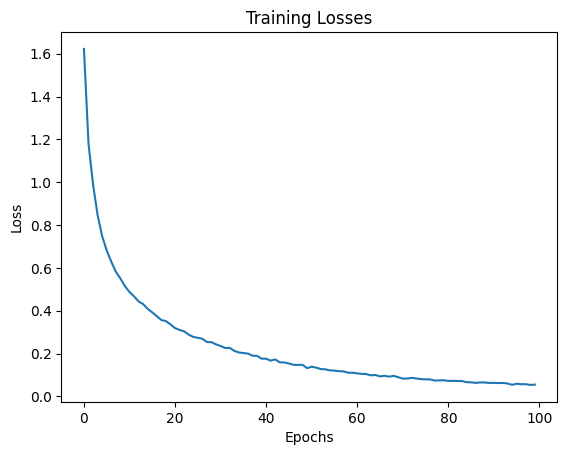

In [193]:

plt.plot(training_losses);
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
print(max(training_losses));

In [196]:
torch.save(model.state_dict(), 'resnet_18_SGD.pth')

In [229]:
from PIL import Image

# Load and resize the image
image = Image.open("input.jpg")  # Replace "your_image.jpg" with the path to your image
resized_image = image.resize((32, 32))

# Convert the resized image to a tensor
transform = transforms.Compose([
    transforms.ToTensor()   
])
tensor_image = transform(resized_image)

# Normalize the tensor image
normalize = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
normalized_image = normalize(tensor_image)

# Add a batch dimension to the tensor image
batched_image = torch.unsqueeze(normalized_image, 0)
batched_image=batched_image.to(device)
classes=["airplane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
answer=model(batched_image);
print(answer)
print("This image is a",classes[torch.argmax(answer, dim=1)])

This image is a bird
